In [67]:
print("Loading numpy...")
import numpy as np
print("Loading torch...")
import torch
torch.set_default_dtype(torch.float64)
print("Loading e3nn...")
import e3nn
import torch_geometric as tg
print("Loading time...")
import time
from collections.abc import Mapping
print("Loading sparse_kernel_conv...")
from sparse_kernel_conv import SparseKernelConv, DummyConvolution
print("Loading laurent...")
from laurent import LaurentPolynomial
print("Loading functools...")
from functools import partial
print("Loading variable_networks...")
from variable_networks import VariableParityNetwork
print("Loading diagnostics...")
from diagnostics import print_parameter_size, count_parameters, get_object_size
print("Loading collections...")
from collections import deque
print("Loading copy...")
from copy import copy
print("Loading datetime...")
from datetime import timedelta
print("Loading re...")
import re
print("Loading sys...")
import sys
print("Loading os...")
import os
import traceback
print("Loading math...")
import math
print("Loading glob...")
from glob import glob

import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from IPython.display import display, HTML
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import cctk, glob, re
import e3nn.point.data_helpers as dh 

print("done loading modules.\n", flush=True)

os.environ["CUDA_VISIBLE_DEVICES"]=""
device = "cpu"
torch.device(device)
temp_tensor = torch.rand(10).to(device)
print("test tensor:")
print(temp_tensor)

Loading numpy...
Loading torch...
Loading e3nn...
Loading time...
Loading sparse_kernel_conv...
Loading laurent...
Loading functools...
Loading variable_networks...
Loading diagnostics...
Loading collections...
Loading copy...
Loading datetime...
Loading re...
Loading sys...
Loading os...
Loading math...
Loading glob...
done loading modules.

test tensor:
tensor([0.2735, 0.4531, 0.0023, 0.4026, 0.3348, 0.3837, 0.1712, 0.0858, 0.7758,
        0.7531])


In [2]:
# read the model from disk
model_filename = "checkpoints/fluidstack_7-e003_b172869-checkpoint.torch"

print(f"Loading model from {model_filename}...", end="", flush=True)
model_dict = torch.load(model_filename, map_location=torch.device('cpu'))
print("done.", flush=True)

Loading model from checkpoints/fluidstack_7-e003_b172869-checkpoint.torch...done.


In [294]:
model_kwargs = model_dict['model_kwargs']
model = VariableParityNetwork(**model_kwargs)
model.load_state_dict(model_dict["state_dict"])
all_elements = model_dict["all_elements"]

# generates one-hots for a list of atomic_symbols
def get_one_hots(atomic_symbols):
    one_hots = []
    for symbol in atomic_symbols:
        inner_list = [ 1. if symbol == i else 0. for i in all_elements ]
        one_hots.append(inner_list)
    return torch.tensor(one_hots, dtype=torch.float64)

In [308]:
class Molecule():
    # filename : relative path to Gaussian .out file that contains a bunch of Link1 NMR jobs
    # classifications : { 1-indexed atom number : [ label1, label2, ... ] }
    # symmetrical_atom_numbers : [ [atom_number1, atom_number2], [atom_number3, atom_number4, atom_number5], ... ]
    #
    # fields:
    # atomic_numbers, one_hots, stationary_geometry, stationary_shieldings_dft, stationary_shieldings_nn
    # jiggled_geometries, jiggled_shieldings_dft, jiggled_shieldings_nn,
    # nuclei, shift_labels, metatags (parallel indexed lists)
    def __init__(self, filename, classifications={}, symmetrical_atom_numbers=[]):
        # read NMR job file
        # first geometry is stationary, rest are jiggles
        outfiles = cctk.GaussianFile.read_file(filename)
        for i,outfile in enumerate(outfiles):
            molecule = outfile.get_molecule()
            if i==0:
                # generate the NMR scaling factors for the first molecule, since it's the same for all others
                atomic_numbers = molecule.atomic_numbers
                unique_atomic_numbers = set(atomic_numbers)
                scaling_factors = { cctk.helper_functions.get_symbol(a) : (-1.0,0.0) for a in unique_atomic_numbers }
                
                # generate one-hots
                one_hots = []
                for symbol in molecule.atomic_numbers.view(np.ndarray):
                    inner_list = [ 1. if symbol == i else 0. for i in all_elements ]
                    one_hots.append(inner_list)
                one_hots = torch.tensor(one_hots, dtype=torch.float64)
                self.atomic_numbers, self.one_hots = atomic_numbers, one_hots
                
            geometry = torch.tensor(molecule.geometry.view(np.ndarray), dtype=torch.float64)
            ensemble = outfile.ensemble
            shieldings, shift_labels = cctk.helper_functions.scale_nmr_shifts(ensemble, symmetrical_atom_numbers, scaling_factors)
            shieldings, shift_labels = shieldings[0], shift_labels[0]
            
            if i==0:
                # create metatags for each site using classification data
                nuclei, metatags = [], []  # parallel indexing to shieldings and shift_labels
                for shift_label in shift_labels:
                    shift_label = shift_label.split("/")[0]
                    nucleus = re.sub(r"[0-9]","",shift_label)
                    nuclei.append(nucleus)
                    shift_label = re.sub(r"[^0-9]","",shift_label)
                    shift_label = int(shift_label)
                    if shift_label in classifications:
                        metatags.append(classifications[shift_label])
                    else:
                        metatags.append("")
                
                # store stationary data and initialize lists
                self.stationary_geometry = geometry
                self.stationary_shieldings_dft = shieldings
                self.shift_labels = shift_labels
                self.metatags = metatags
                self.nuclei = nuclei
                self.jiggled_geometries = []
                self.jiggled_shieldings_dft = []
                self.jiggled_shieldings_nn = []
            else:
                # store jiggled data
                self.jiggled_geometries.append(geometry)
                self.jiggled_shieldings_dft.append(shieldings)

            # make neural network predictions
            data = dh.DataNeighbors(x=self.one_hots, Rs_in = model_kwargs["Rs_in"], pos = geometry,
                                    r_max=model_kwargs["max_radius"], Rs_out=model_kwargs["Rs_out"])
            model.eval()  # because of batchnorm
            with torch.no_grad():  # do not compute gradients
                output = model(data.x, data.edge_index, data.edge_attr, n_norm=model_kwargs["n_norm"])
                
            # convert back to numpy, then cctk, then symmetry-average
            shieldings = output.numpy().reshape(-1)
            shieldings = cctk.OneIndexedArray(shieldings)
            ensemble[0,"nn_shieldings"] = shieldings
            shieldings, shift_labels = cctk.helper_functions.scale_nmr_shifts(ensemble,
                                                                              symmetrical_atom_numbers, scaling_factors,
                                                                              property_name="nn_shieldings")
            shieldings = shieldings[0]

            if i == 0:
                self.stationary_shieldings_nn = shieldings
            else:
                self.jiggled_shieldings_nn.append(shieldings)

In [311]:
metadata_df = pd.read_excel("metadata.xls")
display(metadata_df.head(7))

# parse the metadata
metadata_dict = {} # molecule name : (classifications, symmetrical_atom_numbers)
classifications, symmetrical_atom_numbers = {}, []
for i,row in metadata_df.iterrows():
    # read the data on this spreadsheet row
    molecule_name, entry_type, field1, field2 = row.molecule, row["entry type"], row.field1, row.field2

    # parse the metadata
    if entry_type == "classification":
        description, atom_numbers = field1, str(field2).split(",")
        #print(description, atom_numbers)
        for a in atom_numbers:
            a = int(a)
            if a in classifications:
                old_description = classifications[a]
                classifications[a] = old_description + ", " + description
            else:
                classifications[a] = description
    elif entry_type == "symmetrical":
        temp_list = field1.split(",")
        temp_list = [ int(a) for a in temp_list ]
        symmetrical_atom_numbers.append(temp_list)
    else:
        print(molecule_name, entry_type, field1, field2)
        raise ValueError("unrecognized entry type")

    # check if we are at the end of the metadata or the next row corresponds to a different molecule
    if i + 1 == len(metadata_df) or metadata_df.iloc[i+1].molecule != molecule_name:
        metadata_dict[molecule_name] = (classifications, symmetrical_atom_numbers)
        classifications, symmetrical_atom_numbers = {}, []
        
# create Molecule objects and predict shifts
molecule_dict = {} # molecule name : Molecule
for molecule_name, (classifications, symmetrical_atom_numbers) in metadata_dict.items():
    print(molecule_name)
    filename = f"../../../testing/final_nmrs/{molecule_name}_nmr.out"
    molecule = Molecule(filename, classifications, symmetrical_atom_numbers)
    molecule_dict[molecule_name] = molecule

,molecule,entry type,field1,field2
0,2-chloropyridine,classification,aryl CH,"3,8,4,9,5,10,6,11"
1,2-chloropyridine,classification,aryl CCl,"1,2"
2,2-chlorotoluene,classification,aryl CH,"6,15,5,14,4,13,3,12"
3,2-chlorotoluene,classification,aryl CR,2
4,2-chlorotoluene,classification,CH3,"1,9,10,11"
5,2-chlorotoluene,symmetrical,"9,10,11",NaN
6,3-fluoroaniline,classification,aryl CF,"6,7"


2-chloropyridine
2-chlorotoluene
3-fluoroaniline
13-dichlorobenzene
acetaldehyde
acetic_acid
acetone
acetonitrile
acetyl_chloride
acetylene
acrolein
allene
ammonia
benzaldehyde
benzene
carbon_dioxide
chlorobenzene
cis-2-butene
cyclobutane
cyclopentadiene
cyclopropane_aldehyde
cyclopropane
DCE
dichloromethane
dimethyl_ether
DMSO
ethane
ethylene_glycol
ethylene
ethylene_oxide
ethylene_sulfide
fluorobenzene
formaldehyde
formamide
furan
furfural
hexafluorobenzene
HFIP
imidazole
isobutylene
methane
methanesulfonic_acid
methanol
methyl_formate
methylamine
MTBE
nitromethane
o-cresol
phenol
phenyl_methyl_sulfone
propargylamine
pyridine_N-oxide
pyridine
pyrrole
resorcinol
tert-butyl_sulfinamide
tetrafluoromethane
tetrahydrofuran
tetrahydropyran
thiophene
thiophenol
toluenesulfonic_acid
trans-2-butene
triethylamine
trifluorotoluene
water


In [312]:
# look at dynamic correction errors
temp_molecule_names, temp_nuclei, temp_shift_labels, temp_metatags, temp_jiggle_index = [], [], [], [], []
temp_dynamic_corrections_dft, temp_dynamic_corrections_nn = [], []

for molecule_name, molecule in molecule_dict.items():
    stationary_shieldings_dft, stationary_shieldings_nn = molecule.stationary_shieldings_dft, molecule.stationary_shieldings_nn
    jiggled_shieldings_dft, jiggled_shieldings_nn = np.array(molecule.jiggled_shieldings_dft), np.array(molecule.jiggled_shieldings_nn)
    
    dynamic_corrections_dft = jiggled_shieldings_dft - stationary_shieldings_dft
    dynamic_corrections_nn = jiggled_shieldings_nn - stationary_shieldings_nn
    n = len(dynamic_corrections_dft)
        
    for i,(dft,nn) in enumerate(zip(dynamic_corrections_dft,dynamic_corrections_nn)):
        temp_molecule_names.extend([molecule_name]*n)
        temp_nuclei.extend(molecule.nuclei)
        temp_shift_labels.extend(molecule.shift_labels)
        temp_metatags.extend(molecule.metatags)
        temp_jiggle_index.extend([i]*n)
        temp_dynamic_corrections_dft.extend(dft)
        temp_dynamic_corrections_nn.extend(nn)
    
dynamic_corrections_df = DataFrame([temp_molecule_names, temp_nuclei, temp_shift_labels,
                                    temp_metatags, temp_jiggle_index, temp_dynamic_corrections_dft, temp_dynamic_corrections_nn]).T
dynamic_corrections_df.columns = ["molecule", "nucleus", "shift_label", "tags", "jiggle_index", "dyn_dft", "dyn_nn"]
dynamic_corrections_df["abs_residual"] = dynamic_corrections_df["dyn_nn"] - dynamic_corrections_df["dyn_dft"]
dynamic_corrections_df["rel_residual"] = dynamic_corrections_df["abs_residual"] * 100.0 / dynamic_corrections_df["dyn_dft"]
display(dynamic_corrections_df.head(30))
print(np.shape(dynamic_corrections_df))

,molecule,nucleus,shift_label,tags,jiggle_index,dyn_dft,dyn_nn,abs_residual,rel_residual
0,2-chloropyridine,Cl,Cl1,aryl CCl,0,36.7316,32.4584,-4.27317,-11.6335
1,2-chloropyridine,H,H8,aryl CH,0,0.194,0.467211,0.273211,140.83
2,2-chloropyridine,H,H9,aryl CH,0,-0.5479,-0.115673,0.432227,-78.888
3,2-chloropyridine,H,H10,aryl CH,0,-1.4196,-2.23232,-0.81272,57.2499
4,2-chloropyridine,H,H11,aryl CH,0,0.2204,-0.00681159,-0.227212,-103.091
5,2-chloropyridine,C,C2,aryl CCl,0,-3.9198,-5.31692,-1.39712,35.6426
6,2-chloropyridine,C,C3,aryl CH,0,-1.6936,1.84015,3.53375,-208.653
7,2-chloropyridine,C,C4,aryl CH,0,-0.9893,1.17544,2.16474,-218.815
8,2-chloropyridine,C,C5,aryl CH,0,-0.7716,-0.59328,0.17832,-23.1104
9,2-chloropyridine,C,C6,aryl CH,0,-6.0776,-6.3774,-0.299803,4.93292


(6600, 9)


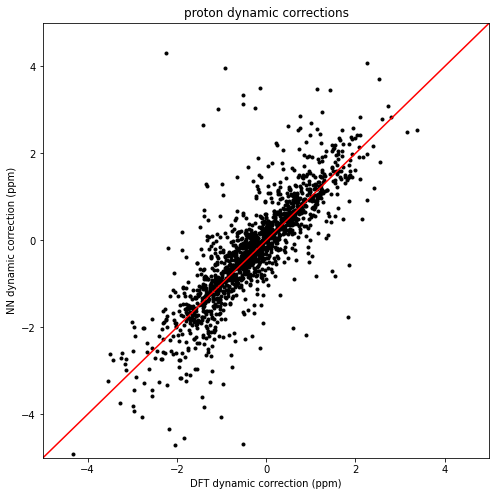

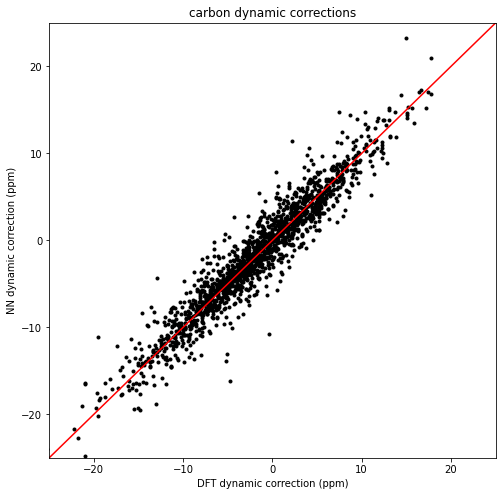

In [313]:
df = dynamic_corrections_df.query("nucleus=='H'")
x = np.linspace(-5,5,100)
plt.figure(figsize=(8,8))
plt.title("proton dynamic corrections")
plt.plot(df.dyn_dft, df.dyn_nn, 'k.')
plt.plot(x,x,"r-")
plt.xlabel("DFT dynamic correction (ppm)")
plt.ylabel("NN dynamic correction (ppm)")
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
df = dynamic_corrections_df.query("nucleus=='C'")
x = np.linspace(-25,25,100)
plt.figure(figsize=(8,8))
plt.title("carbon dynamic corrections")
plt.plot(df.dyn_dft, df.dyn_nn, 'k.')
plt.plot(x,x,"r-")
plt.xlabel("DFT dynamic correction (ppm)")
plt.ylabel("NN dynamic correction (ppm)")
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.show()

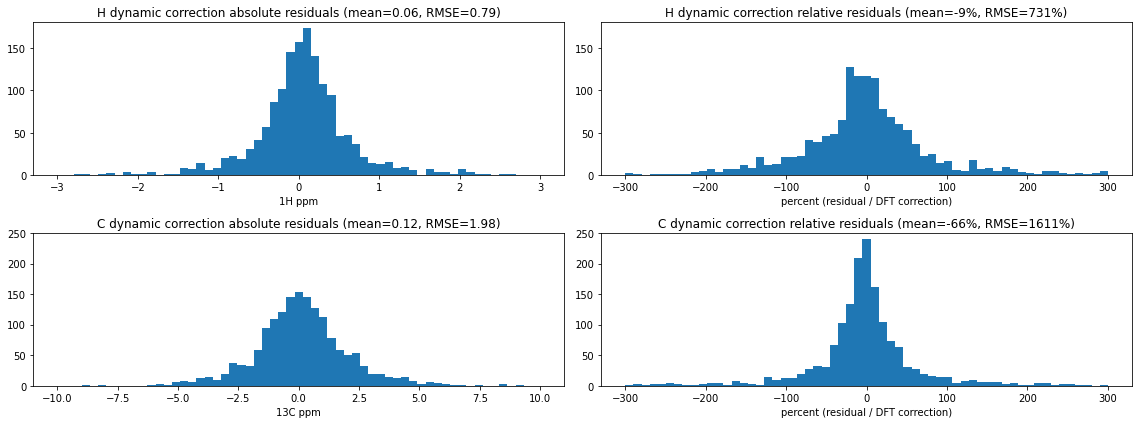

In [314]:
df = dynamic_corrections_df.query("nucleus=='H'")
fig,ax = plt.subplots(2,2,figsize=(16,6))
ax[0,0].set_title(f"H dynamic correction absolute residuals (mean={np.mean(df.abs_residual):.2f}, RMSE={np.std(df.abs_residual):.2f})")
ax[0,0].hist(df.abs_residual, bins=np.linspace(-3,3,60))
ax[0,0].set_xlabel("1H ppm")
ax[0,0].set_ylim(0,180)
ax[0,1].set_title(f"H dynamic correction relative residuals (mean={np.mean(df.rel_residual):.0f}%, RMSE={np.std(df.rel_residual):.0f}%)")
ax[0,1].hist(df.rel_residual, bins=np.linspace(-300,300,60))
ax[0,1].set_xlabel("percent (residual / DFT correction)")
ax[0,1].set_ylim(0,180)
df = dynamic_corrections_df.query("nucleus=='C'")
ax[1,0].set_title(f"C dynamic correction absolute residuals (mean={np.mean(df.abs_residual):.2f}, RMSE={np.std(df.abs_residual):.2f})")
ax[1,0].hist(df.abs_residual, bins=np.linspace(-10,10,60))
ax[1,0].set_xlabel("13C ppm")
ax[1,0].set_ylim(0,250)
ax[1,1].set_title(f"C dynamic correction relative residuals (mean={np.mean(df.rel_residual):.0f}%, RMSE={np.std(df.rel_residual):.0f}%)")
ax[1,1].hist(df.rel_residual, bins=np.linspace(-300,300,60))
ax[1,1].set_xlabel("percent (residual / DFT correction)")
ax[1,1].set_ylim(0,250)
plt.tight_layout()
plt.show()

In [353]:
# look at generalization errors

temp_molecule_names, temp_nuclei, temp_shift_labels, temp_metatags, temp_jiggle_index = [], [], [], [], []
temp_stationary_dft, temp_stationary_nn = [], []
for molecule_name, molecule in molecule_dict.items():
    stationary_shieldings_dft, stationary_shieldings_nn = molecule.stationary_shieldings_dft, molecule.stationary_shieldings_nn
    temp_stationary_dft.extend(stationary_shieldings_dft)
    temp_stationary_nn.extend(stationary_shieldings_nn)
    n = len(stationary_shieldings_dft)
    temp_molecule_names.extend([molecule_name]*n)
    temp_nuclei.extend(molecule.nuclei)
    temp_shift_labels.extend(molecule.shift_labels)
    temp_metatags.extend(molecule.metatags)
    temp_jiggle_index.extend(["stationary"]*n)
    
generalization_df = DataFrame([temp_molecule_names, temp_nuclei, temp_shift_labels,
                                    temp_metatags, temp_jiggle_index, 
                                    temp_stationary_dft, temp_stationary_nn]).T
generalization_df.columns = ["molecule", "nucleus", "shift_label", "tags", "jiggle_index",
                                  "stationary_dft", "stationary_nn"]
generalization_df["abs_residual"] = generalization_df["stationary_nn"] - generalization_df["stationary_dft"]
display(generalization_df.head())

,molecule,nucleus,shift_label,tags,jiggle_index,stationary_dft,stationary_nn,abs_residual
0,2-chloropyridine,Cl,Cl1,aryl CCl,stationary,615.029,628.466,13.4369
1,2-chloropyridine,H,H8,aryl CH,stationary,24.0787,23.5179,-0.560792
2,2-chloropyridine,H,H9,aryl CH,stationary,23.686,23.515,-0.170964
3,2-chloropyridine,H,H10,aryl CH,stationary,24.2353,24.3665,0.131187
4,2-chloropyridine,H,H11,aryl CH,stationary,22.8389,22.6917,-0.147181


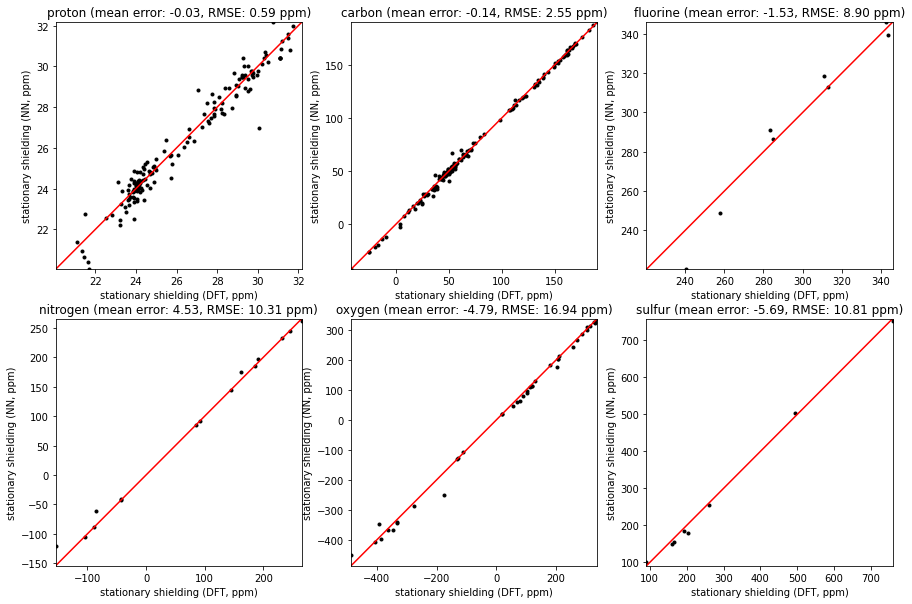

In [341]:
nuclei_dict = {"H":("proton",(0,0)), "C":("carbon",(0,1)), "N":("nitrogen",(1,0)),
               "O":("oxygen",(1,1)), "F":("fluorine",(0,2)), "S":("sulfur",(1,2))}

fig,ax = plt.subplots(2,3,figsize=(15,10))
for abbrev,(nucleus,loc) in nuclei_dict.items():
    df = generalization_df.query(f"nucleus=='{abbrev}'")
    min_val, max_val = df[["stationary_dft","stationary_nn"]].values.min(), df[["stationary_dft","stationary_nn"]].values.max()
    x = np.linspace(min_val,max_val,100)
    mean_error, RMSE = np.mean(df.abs_residual), np.std(df.abs_residual)
    ax[loc].set_title(f"{nucleus} (mean error: {mean_error:.2f}, RMSE: {RMSE:.2f} ppm)")
    ax[loc].plot(df.stationary_dft, df.stationary_nn, 'k.')
    ax[loc].plot(x,x,"r-")
    ax[loc].set_xlabel("stationary shielding (DFT, ppm)")
    ax[loc].set_ylabel("stationary shielding (NN, ppm)")
    ax[loc].set_xlim(min_val,max_val)
    ax[loc].set_ylim(min_val,max_val)
plt.show()

In [350]:
# look at generalization errors over jiggles
temp_molecule_names, temp_nuclei, temp_shift_labels, temp_metatags, temp_jiggle_index = [], [], [], [], []
temp_jiggled_dft, temp_jiggled_nn = [], []
for molecule_name, molecule in molecule_dict.items():
    jiggled_shieldings_dft, jiggled_shieldings_nn = np.array(molecule.jiggled_shieldings_dft), np.array(molecule.jiggled_shieldings_nn)
    n = len(molecule.nuclei)
        
    for i,(dft,nn) in enumerate(zip(jiggled_shieldings_dft,jiggled_shieldings_nn)):
        temp_molecule_names.extend([molecule_name]*n)
        temp_nuclei.extend(molecule.nuclei)
        temp_shift_labels.extend(molecule.shift_labels)
        temp_metatags.extend(molecule.metatags)
        temp_jiggle_index.extend([i]*n)
        temp_jiggled_dft.extend(dft)
        temp_jiggled_nn.extend(nn)    
    
generalization_df = DataFrame([temp_molecule_names, temp_nuclei, temp_shift_labels,
                                    temp_metatags, temp_jiggle_index, 
                                    temp_jiggled_dft, temp_jiggled_nn]).T
generalization_df.columns = ["molecule", "nucleus", "shift_label", "tags", "jiggle_index",
                                  "jiggled_dft", "jiggled_nn"]
generalization_df["abs_residual"] = generalization_df["jiggled_nn"] - generalization_df["jiggled_dft"]
display(generalization_df)


,molecule,nucleus,shift_label,tags,jiggle_index,jiggled_dft,jiggled_nn,abs_residual
0,2-chloropyridine,Cl,Cl1,aryl CCl,0,651.761,660.924,9.16374
1,2-chloropyridine,H,H8,aryl CH,0,24.2727,23.9851,-0.287582
2,2-chloropyridine,H,H9,aryl CH,0,23.1381,23.3994,0.261263
3,2-chloropyridine,H,H10,aryl CH,0,22.8157,22.1342,-0.681533
4,2-chloropyridine,H,H11,aryl CH,0,23.0593,22.6849,-0.374393
...,...,...,...,...,...,...,...,...
3955,water,H,H2/3,OH,7,31.6314,29.9987,-1.63271
3956,water,O,O1,OH,8,354.675,352.354,-2.32142
3957,water,H,H2/3,OH,8,32.8738,32.6577,-0.216058
3958,water,O,O1,OH,9,345.313,338.464,-6.84829


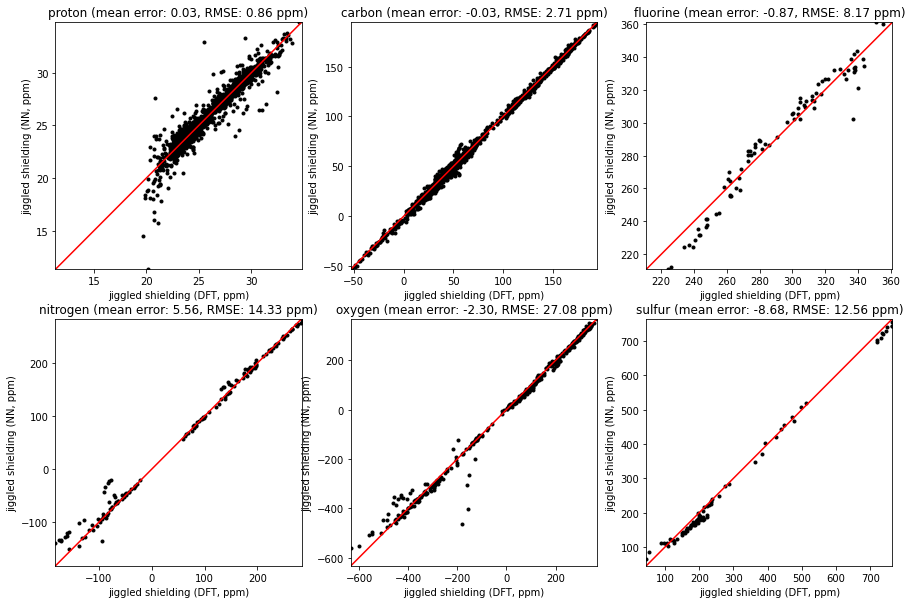

In [352]:
nuclei_dict = {"H":("proton",(0,0)), "C":("carbon",(0,1)), "N":("nitrogen",(1,0)),
               "O":("oxygen",(1,1)), "F":("fluorine",(0,2)), "S":("sulfur",(1,2))}

fig,ax = plt.subplots(2,3,figsize=(15,10))
for abbrev,(nucleus,loc) in nuclei_dict.items():
    df = generalization_df.query(f"nucleus=='{abbrev}'")
    min_val, max_val = df[["jiggled_dft","jiggled_nn"]].values.min(), df[["jiggled_dft","jiggled_nn"]].values.max()
    x = np.linspace(min_val,max_val,100)
    mean_error, RMSE = np.mean(df.abs_residual), np.std(df.abs_residual)
    ax[loc].set_title(f"{nucleus} (mean error: {mean_error:.2f}, RMSE: {RMSE:.2f} ppm)")
    ax[loc].plot(df.jiggled_dft, df.jiggled_nn, 'k.')
    ax[loc].plot(x,x,"r-")
    ax[loc].set_xlabel("jiggled shielding (DFT, ppm)")
    ax[loc].set_ylabel("jiggled shielding (NN, ppm)")
    ax[loc].set_xlim(min_val,max_val)
    ax[loc].set_ylim(min_val,max_val)
plt.show()

In [219]:
# look at dynamic correction errors
temp_molecule_names, temp_nuclei, temp_shift_labels, temp_metatags, temp_mean_residuals, temp_RMS_residuals = [], [], [], [], [], []

for molecule_name, molecule in molecule_dict.items():
    stationary_shieldings_dft, stationary_shieldings_nn = molecule.stationary_shieldings_dft, molecule.stationary_shieldings_nn
    jiggled_shieldings_dft, jiggled_shieldings_nn = np.array(molecule.jiggled_shieldings_dft), np.array(molecule.jiggled_shieldings_nn)
    
    dynamic_corrections_dft = []
    for shieldings in jiggled_shieldings_dft:
        correction = shieldings - stationary_shieldings_dft
        dynamic_corrections_dft.append(correction)
    
    dynamic_corrections_nn = []
    for shieldings in jiggled_shieldings_nn:
        correction = shieldings - stationary_shieldings_nn
        dynamic_corrections_nn.append(correction)
    
    residuals = []
    for corrections_dft,corrections_nn in zip(dynamic_corrections_dft, dynamic_corrections_nn):
        this_residuals = corrections_nn - corrections_dft
        residuals.append(this_residuals)
    residuals = np.array(residuals)
    
    mean_residuals = list(np.mean(residuals, axis=0))
    RMS_residuals = list(np.std(residuals, axis=0))
    
    temp_molecule_names.extend([molecule_name]*len(molecule.nuclei))
    temp_nuclei.extend(molecule.nuclei)
    temp_shift_labels.extend(molecule.shift_labels)
    temp_metatags.extend(molecule.metatags)
    temp_mean_residuals.extend(mean_residuals)
    temp_RMS_residuals.extend(RMS_residuals)

dynamic_corrections_df = DataFrame([temp_molecule_names, temp_nuclei, temp_shift_labels,
                                    temp_metatags, temp_mean_residuals, temp_RMS_residuals]).T
dynamic_corrections_df.columns = ["molecule", "nucleus", "shift_label", "tags", "mean_error", "RMSE"]

display(dynamic_corrections_df.head())
print(np.shape(dynamic_corrections_df))

,molecule,nucleus,shift_label,tags,mean_error,RMSE
0,2-chloropyridine,Cl,Cl1,aryl CCl,-1.61116,9.42462
1,2-chloropyridine,H,H8,aryl CH,-0.0693272,0.27449
2,2-chloropyridine,H,H9,aryl CH,-0.347698,0.237715
3,2-chloropyridine,H,H10,aryl CH,0.310197,0.42781
4,2-chloropyridine,H,H11,aryl CH,-0.116871,0.638899


(396, 6)


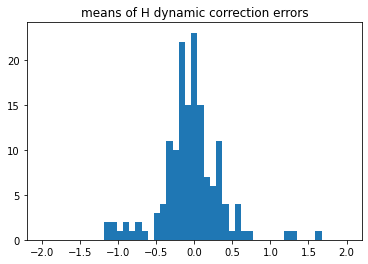

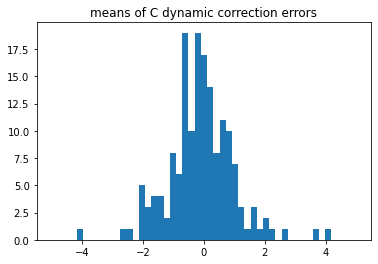

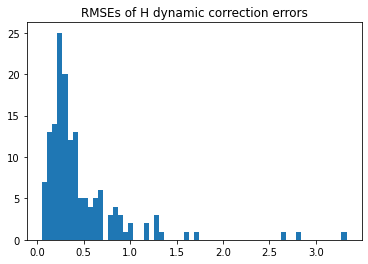

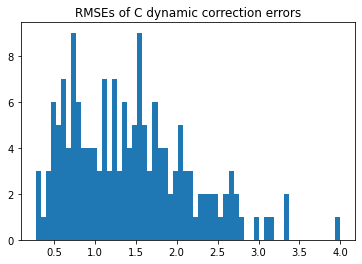

In [234]:
df = dynamic_corrections_df.query("nucleus == 'H'")
plt.title("means of H dynamic correction errors")
plt.hist(df.mean_error, bins=np.linspace(-2.0,2.0,50))
plt.show()
plt.title("means of C dynamic correction errors")
df = dynamic_corrections_df.query("nucleus == 'C'")
plt.hist(df.mean_error, bins=np.linspace(-5.0,5.0,50))
plt.show()
df = dynamic_corrections_df.query("nucleus == 'H'")
plt.title("RMSEs of H dynamic correction errors")
plt.hist(df.RMSE, bins=60)
plt.show()
plt.title("RMSEs of C dynamic correction errors")
df = dynamic_corrections_df.query("nucleus == 'C'")
plt.hist(df.RMSE, bins=60)
plt.show()

In [ ]:
# look at dynamic correction errors
temp_molecule_names, temp_nuclei, temp_shift_labels, temp_metatags, temp_jiggle_index, temp_residuals = [], [], [], [], [], []

for molecule_name, molecule in molecule_dict.items():
    stationary_shieldings_dft, stationary_shieldings_nn = molecule.stationary_shieldings_dft, molecule.stationary_shieldings_nn
    jiggled_shieldings_dft, jiggled_shieldings_nn = np.array(molecule.jiggled_shieldings_dft), np.array(molecule.jiggled_shieldings_nn)
    
    molecule.dynamic_corrections_dft = []
    for shieldings in jiggled_shieldings_dft:
        correction = shieldings - stationary_shieldings_dft
        molecule.dynamic_corrections_dft.append(correction)
    molecule.dynamic_corrections_nn = []
    for shieldings in jiggled_shieldings_nn:
        correction = shieldings - stationary_shieldings_nn
        molecule.dynamic_corrections_nn.append(correction)
    dynamic_residuals = []
    for corrections_dft,corrections_nn in zip(molecule.dynamic_corrections_dft, molecule.dynamic_corrections_nn):
        residuals = corrections_nn - corrections_dft
        dynamic_residuals.append(residuals)
        
    for i,residuals in enumerate(dynamic_residuals):
        temp_molecule_names.extend([molecule_name]*len(residuals))
        temp_nuclei.extend(molecule.nuclei)
        temp_shift_labels.extend(molecule.shift_labels)
        temp_metatags.extend(molecule.metatags)
        temp_jiggle_index.extend([i]*len(residuals))
        temp_residuals.extend(residuals)
    
dynamic_corrections_df = DataFrame([temp_molecule_names, temp_nuclei, temp_shift_labels,
                                    temp_metatags, temp_jiggle_index, temp_residuals]).T
dynamic_corrections_df.columns = ["molecule", "nucleus", "shift_label", "tags", "jiggle_index", "residual"]
display(dynamic_corrections_df.head(30))
print(np.shape(dynamic_corrections_df))